# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import findspark
findspark.init("/Users/ayemyatwinshwe/opt/spark-3.0.0-preview2-bin-hadoop2.7")

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Read in sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# number of records
df.count()

286500

In [7]:
# check number of missing values in each column
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df.columns]
df.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
df.select("auth").dropDuplicates().sort("userId").show()

+----------+
|      auth|
+----------+
|     Guest|
|Logged Out|
| Cancelled|
| Logged In|
+----------+



In [9]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [10]:
df_valid = df.dropna(how="any", subset=["userId", "sessionId"])

In [11]:
# filter out empty userId's
df_valid = df_valid.filter(df['userId'] != "")

In [12]:
# fill missing values of length with 0
df_valid = df_valid.na.fill(0, subset=['length'])

In [13]:
# check number of missing values in each column again
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df_valid.columns]
df_valid.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [14]:
df_valid.filter(F.col('artist').isNull()).select(
    'page').dropDuplicates().show(20, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [15]:
df_valid.filter(F.col('artist').isNotNull()).select(
    'page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [16]:
# number of users
df.select("userId").dropDuplicates().count()

226

In [17]:
# number of artists
df.select("artist").dropDuplicates().count()

17656

In [18]:
# auth
df.select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [19]:
# itemInSession
df.select("itemInSession").describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141085|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [20]:
# length
df.select("length").describe().show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783722|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fccb0565190>]],
      dtype=object)

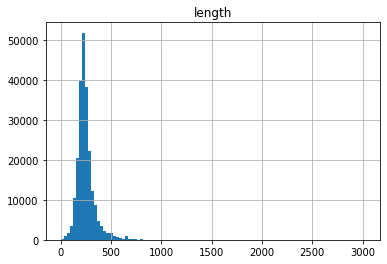

In [21]:
# histogram for length
df.select("length").toPandas().hist(bins=100)

In [22]:
# level
df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [23]:
# location
df.select("location").dropDuplicates().show(20, False)

+---------------------------------------+
|location                               |
+---------------------------------------+
|Gainesville, FL                        |
|Atlantic City-Hammonton, NJ            |
|Deltona-Daytona Beach-Ormond Beach, FL |
|San Diego-Carlsbad, CA                 |
|Cleveland-Elyria, OH                   |
|Kingsport-Bristol-Bristol, TN-VA       |
|New Haven-Milford, CT                  |
|Birmingham-Hoover, AL                  |
|Corpus Christi, TX                     |
|Dubuque, IA                            |
|Las Vegas-Henderson-Paradise, NV       |
|Indianapolis-Carmel-Anderson, IN       |
|Seattle-Tacoma-Bellevue, WA            |
|Albany, OR                             |
|Winston-Salem, NC                      |
|Bakersfield, CA                        |
|Los Angeles-Long Beach-Anaheim, CA     |
|Minneapolis-St. Paul-Bloomington, MN-WI|
|San Francisco-Oakland-Hayward, CA      |
|Phoenix-Mesa-Scottsdale, AZ            |
+---------------------------------

In [24]:
# method
df.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [25]:
# page
df.select("page").dropDuplicates().show(22, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [26]:
# registration
df.select("registration").show(5)

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
+-------------+
only showing top 5 rows



In [27]:
# songs
df.select("song").show(5, False)

+-----------------------------+
|song                         |
+-----------------------------+
|Rockpools                    |
|Canada                       |
|Time For Miracles            |
|Knocking On Forbidden Doors  |
|Harder Better Faster Stronger|
+-----------------------------+
only showing top 5 rows



In [28]:
# number of songs
df.select("song").drop_duplicates().count()

58481

In [29]:
# status
df.select("status").drop_duplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [30]:
# ts
df.select("ts").show(5)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
+-------------+
only showing top 5 rows



In [31]:
# userAgent
df_valid.select("userAgent").drop_duplicates().show(10, False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


## Define Churn

Define churn events as`Cancellation Confirmation` events or `Downgrade` events.
Create a column `churn` to use as the label for the model. 

In [32]:
# define churn
flag_churn_event = F.udf(lambda x: 1 if (x == 'Cancellation Confirmation') | (
    x == 'Submit Downgrade') else 0, T.IntegerType())

# define churn
flag_churn_event = F.udf(lambda x: 1 if (x == 'Cancellation Confirmation') else 0, T.IntegerType())

In [33]:
# create churn column
df_valid = df_valid.withColumn('churn', flag_churn_event('page'))

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [34]:
# number of users
num_users = df_valid.select(F.countDistinct('userId').alias('num_users')).collect()[0][0]
print("number of users:", num_users)

number of users: 225


In [35]:
# number of churn and not churn users
num_churn_users = df_valid.filter(df_valid['churn']=='1').select(F.countDistinct('userId')).collect()[0][0]
num_not_churn_users = num_users - num_churn_users
print("number of churn users:", num_churn_users)
print("number of not churn users:", num_not_churn_users)

number of churn users: 92
number of not churn users: 133


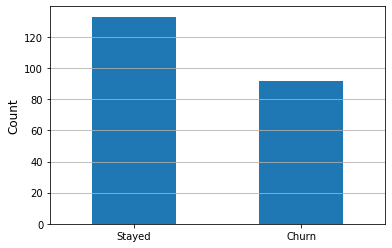

In [36]:
d = {'churns': [num_not_churn_users, num_churn_users]}
df_churns = pd.DataFrame(data=d, index=['Stayed','Churn'])
ax = df_churns.plot.bar(legend=False);
ax.grid(axis='y')
ax.set_ylabel('Count', fontsize = 12)
plt.xticks(rotation=0);

### Gender

In [37]:
num_females = df_valid.filter(df_valid['gender']=='F').select(F.countDistinct('userId')).collect()[0][0]
num_males = num_users - num_females
print("number of females:", num_females)
print("number of males:", num_males)

number of females: 104
number of males: 121


In [38]:
df_gender = df_valid.groupby('gender').sum('churn').toPandas()
df_gender['count']=[num_females, num_males]
df_gender['percent churn'] = df_gender['sum(churn)']/df_gender['count']*100
df_gender.columns = ['gender', 'num_churns', 'count', 'percent churn']
df_gender.set_index('gender')

,num_churns,count,percent churn
gender,,,
F,58,104,55.769231
M,57,121,47.107438


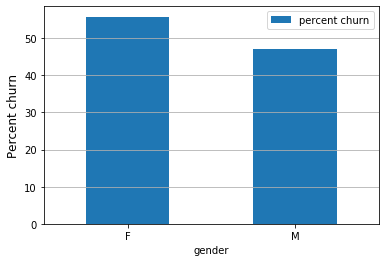

In [39]:
ax = df_gender.plot.bar(x='gender', y='percent churn');
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize = 12)
plt.xticks(rotation=0);

### Level

In [40]:
num_free = df_valid.filter(df_valid['level']=='free').select(F.countDistinct('userId')).collect()[0][0]
num_paid = df_valid.filter(df_valid['level']=='paid').select(F.countDistinct('userId')).collect()[0][0]

In [41]:
df_level = df_valid.groupby('level').sum('churn').toPandas()
df_level['count'] = [num_free, num_paid]
df_level['percent churn'] = df_level['sum(churn)'] / df_level['count'] * 100
df_level.columns = ['level', 'num_churns', 'count', 'percent churn']
df_level.set_index('level')

,num_churns,count,percent churn
level,,,
free,21,195,10.769231
paid,94,165,56.969697


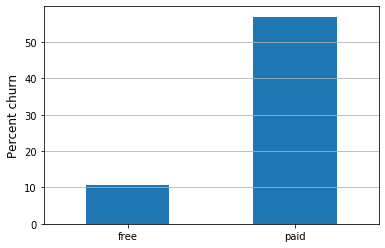

In [42]:
ax = df_level.plot.bar(x='level', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize = 12)
ax.set_xlabel('')
plt.xticks(rotation=0);

### Location

In [43]:
df_valid.select("location").show(10,False)

+------------------------------+
|location                      |
+------------------------------+
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Bakersfield, CA               |
|Bakersfield, CA               |
+------------------------------+
only showing top 10 rows



In [44]:
get_states = F.udf(lambda x: x[-2:])

In [45]:
# create state column
df_valid = df_valid.withColumn("state", get_states(df_valid['location']))

In [46]:
df_state_counts = df_valid.select('userId','state').dropDuplicates().groupby('state').count().toPandas()

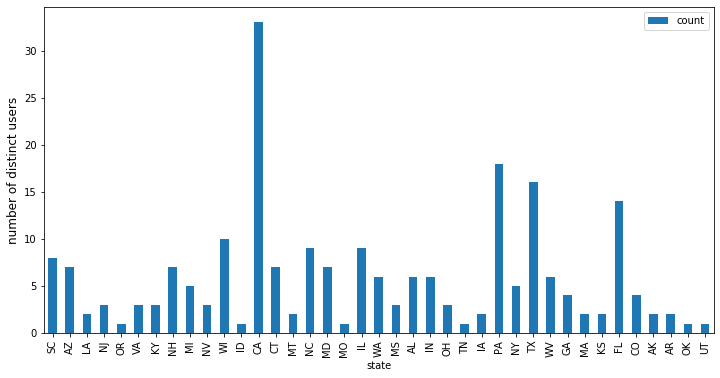

In [47]:
ax = df_state_counts.plot.bar(x='state',y='count', 
                     figsize = (12,6));
ax.set_ylabel('number of distinct users', fontsize=12);

In [48]:
df_state_churns = df_valid.groupby('state').sum('churn').toPandas()
df_state_churns.columns = ['state', 'num_churns']

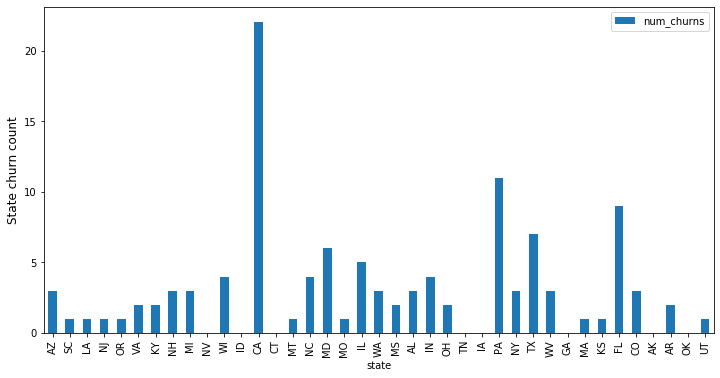

In [49]:
ax = df_state_churns.plot.bar(x='state', y='num_churns', figsize=(12,6));
ax.set_ylabel('State churn count', fontsize=12);

In [50]:
df_state_churns['percent churn'] = df_state_churns['num_churns'] / df_state_counts['count'] * 100

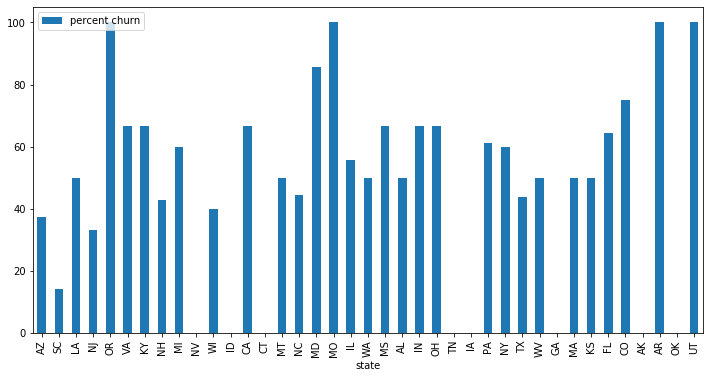

In [51]:
df_state_churns.plot.bar(x='state', y='percent churn', figsize=(12,6));

### Registration

In [52]:
# create datetime columns for registration and timestamp
df_valid = df_valid.withColumn('registration date', (F.col('registration')/1000).cast(T.TimestampType()))
df_valid = df_valid.withColumn('date', (F.col('ts')/1000).cast(T.TimestampType()))

In [53]:
df_valid.select("registration date", "date").show(5)

+-------------------+-------------------+
|  registration date|               date|
+-------------------+-------------------+
|2018-09-28 17:22:42|2018-09-30 19:01:57|
|2018-09-30 13:20:30|2018-09-30 19:03:00|
|2018-09-28 17:22:42|2018-09-30 19:06:34|
|2018-09-30 13:20:30|2018-09-30 19:06:56|
|2018-09-28 17:22:42|2018-09-30 19:11:16|
+-------------------+-------------------+
only showing top 5 rows



In [54]:
# find earliest and latest dates
start_date = df_valid.agg({'date':'min'}).collect()
end_date = df_valid.agg({'date':'max'}).collect()
print("start date:", str(start_date[0][0]))
print("end date:", str(end_date[0][0]))

start date: 2018-09-30 19:01:57
end date: 2018-12-02 19:11:16


In [55]:
# number of days since registration
df_valid = df_valid.withColumn("days_since_reg", (F.datediff("date","registration date")))

In [56]:
df_days_stayed = df_valid.filter(df_valid['churn']==0).select('days_since_reg').toPandas()
df_days_churn = df_valid.filter(df_valid['churn']==1).select('days_since_reg').toPandas()

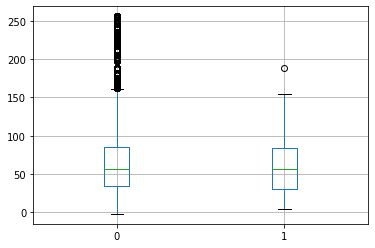

In [57]:
pd.concat([df_days_stayed, df_days_churn], axis=1, ignore_index=True).boxplot();

In [58]:
df_valid.groupby('churn').mean('days_since_reg').show()

+-----+-------------------+
|churn|avg(days_since_reg)|
+-----+-------------------+
|    1| 61.721739130434784|
|    0|  64.76103352407397|
+-----+-------------------+



In [59]:
# user defined functions to get hour and month from timestamp
get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_month = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

In [60]:
# create month columns for registration and timestamp
df_valid = df_valid.withColumn("registration month", get_month(df_valid['registration']))
df_valid = df_valid.withColumn("month", get_month(df_valid['ts']))

monthly_reg_count = []
monthly_count = []

for month in range(9, 13):
    
    reg = df_valid.filter(df_valid['registration month']==month).select('userId').count()
    ts = df_valid.filter(df_valid['month']==month).select('userId').count()
    
    monthly_reg_count.append(reg)
    monthly_count.append(ts)
    
print("monthly registration counts:", monthly_reg_count)
print("monthly counts:", monthly_count)

In [61]:
# flag if the registration month is September
flag_reg_month = F.udf(lambda x: 1 if x == 9 else 0, T.IntegerType())

In [62]:
# create columns for registration month flag
df_valid = df_valid.withColumn("registration month flag", flag_reg_month(df_valid['registration month']))

### Month of Registration

In [63]:
num_Sept = df_valid.filter(df_valid['registration month flag']==1).select(F.countDistinct('userId')).collect()[0][0]
num_not_Sept = num_users - num_Sept
print("number of distinct users who registered in September:", num_Sept)
print("number of distinct users who registered in other months:", num_not_Sept)

number of distinct users who registered in September: 128
number of distinct users who registered in other months: 97


In [64]:
df_valid.groupby('registration month').sum('churn').show()

+------------------+----------+
|registration month|sum(churn)|
+------------------+----------+
|                 7|        11|
|                11|         0|
|                 3|         0|
|                 8|        27|
|                 5|         1|
|                 6|        10|
|                 9|        66|
|                10|         0|
+------------------+----------+



### Song

In [65]:
# create hour column
df_valid = df_valid.withColumn("hour", get_hour(df_valid['ts']))

In [66]:
songs_in_hour = df_valid.filter(df_valid['page'] == "NextSong").groupby(
    df_valid['hour']).count().orderBy(df_valid['hour'].cast("float")).toPandas()

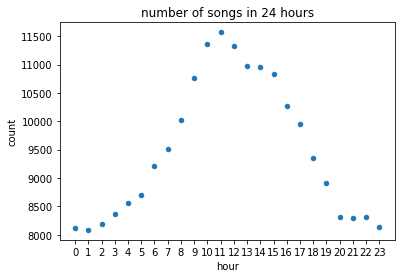

In [67]:
songs_in_hour.plot.scatter(x='hour', y='count', title='number of songs in 24 hours');

In [68]:
# time window to find number of songs played in a day
days = lambda x: x * 86400

windowval = (
    Window.partitionBy("userId")
    .orderBy(F.col("ts")/1000)
    .rangeBetween(-days(1), 0)
)

In [69]:
# number of songs played in a day
df_valid = df_valid.withColumn("num_songs", F.count("song").over(windowval))

In [70]:
def make_boxplot(col_name):
    df_stayed = df_valid.filter(df_valid['churn']==0).select(col_name).toPandas()
    df_churn = df_valid.filter(df_valid['churn']==1).select(col_name).toPandas()
    df = pd.concat([df_stayed, df_churn], axis=1, ignore_index=True)
    df.columns = ['stayed','churn']
    s = df.describe().transpose()
    ax = df.boxplot()
    ax.set_title(col_name + ' per day', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    return s, ax   

(           count        mean        std  min   25%   50%    75%    max
 stayed  278039.0  110.457957  93.990357  0.0  34.0  84.0  164.0  372.0
 churn      115.0   94.626087  83.306606  1.0  33.5  61.0  142.5  347.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb0f69350>)

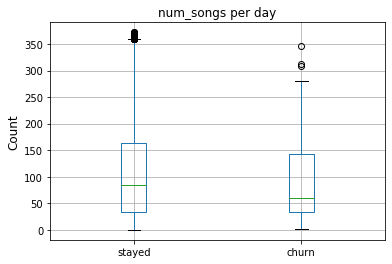

In [71]:
make_boxplot('num_songs')

### Length

In [72]:
# number of songs played in a day
df_valid = df_valid.withColumn("lengths", F.sum("length").over(windowval))

(           count          mean           std        min         25%  \
 stayed  278039.0  27545.241562  23445.852171    0.00000  8393.96358   
 churn      115.0  23486.574650  20646.700404  125.59628  8164.80462   
 
                 50%           75%          max  
 stayed  20867.15066  40776.273580  89040.98619  
 churn   15274.99603  35086.092815  86531.05575  ,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb1601710>)

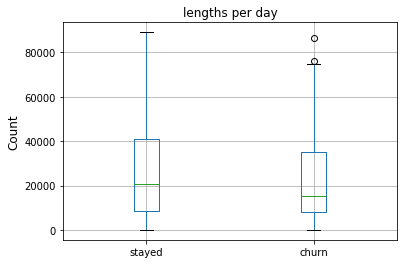

In [73]:
make_boxplot('lengths')

In [74]:
# check song counts
df_valid.select(["userId", 'date','song', 'num_songs','lengths', 'sessionId']).where(df_valid.userId == "33").show(40)

+------+-------------------+--------------------+---------+------------------+---------+
|userId|               date|                song|num_songs|           lengths|sessionId|
+------+-------------------+--------------------+---------+------------------+---------+
|    33|2018-10-01 07:46:24|      Shut Your Eyes|        1|         197.09342|      221|
|    33|2018-10-01 07:49:41|Plumber In Progre...|        2|         697.10276|      221|
|    33|2018-10-01 07:49:42|                null|        2|         697.10276|      221|
|    33|2018-10-01 07:49:45|                null|        2|         697.10276|      221|
|    33|2018-10-01 07:58:01|Chill Out (Things...|        3|         984.24027|      221|
|    33|2018-10-01 08:02:48|              On Top|        4|        1243.13941|      221|
|    33|2018-10-01 08:07:06|Suffragette City ...|        5|        1450.02875|      221|
|    33|2018-10-01 08:10:32|           Fireflies|        6|        1675.20381|      221|
|    33|2018-10-01 08

### Artist

In [75]:
# number of distinct artists played in a day
df_valid = df_valid.withColumn("num_artists", F.size(F.collect_set("artist").over(windowval)))

(           count        mean        std  min   25%   50%    75%    max
 stayed  278039.0  102.900435  84.129481  0.0  33.0  81.0  154.0  332.0
 churn      115.0   88.721739  74.848918  1.0  32.0  61.0  136.5  308.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb0eea790>)

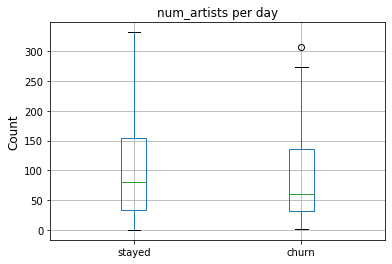

In [76]:
make_boxplot('num_artists')

### Status

In [77]:
df_valid.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [78]:
# number of distinct status in a day
df_valid = df_valid.withColumn("num_status", F.size(F.collect_set("status").over(windowval)))

(           count      mean       std  min  25%  50%  75%  max
 stayed  278039.0  2.025522  0.426505  1.0  2.0  2.0  2.0  3.0
 churn      115.0  2.130435  0.338255  2.0  2.0  2.0  2.0  3.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb0b012d0>)

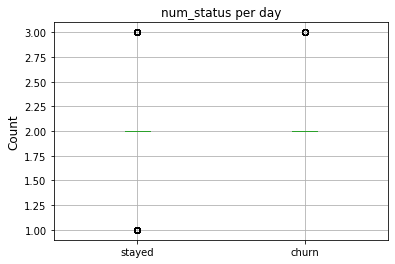

In [79]:
make_boxplot('num_status')

In [80]:
# flag the status 'redirect' and 'not found'
flag_redirect = F.udf(lambda x: 1 if x == 307 else 0, T.IntegerType())
flag_not_found = F.udf(lambda x: 1 if x == 404 else 0, T.IntegerType())

In [81]:
# create redirect and page_not_found columns
df_valid = df_valid.withColumn("redirect", flag_redirect(df_valid['status']))
df_valid = df_valid.withColumn("page_not_found", flag_not_found(df_valid['status']))

In [82]:
df_valid.filter(df_valid['status']=='307').select(F.sum("churn")).show()

+----------+
|sum(churn)|
+----------+
|        63|
+----------+



In [83]:
df_valid.filter(df_valid['status']=='200').select(F.sum("churn")).show()

+----------+
|sum(churn)|
+----------+
|        52|
+----------+



### Page

In [84]:
df_valid.groupby('page').count().show(22,False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



#### Thumps Up/Down

In [85]:
# flag thumps down/up
flag_thumps_down = F.udf(lambda x: 1 if (x == 'Thumbs Down') else 0, T.IntegerType())
flag_thumps_up = F.udf(lambda x: 1 if (x == 'Thumbs Up') else 0, T.IntegerType())

In [86]:
# create flag columns for thumps down and thumps up
df_valid = df_valid.withColumn("thumps_down", flag_thumps_down('page'))
df_valid = df_valid.withColumn("thumps_up", flag_thumps_up('page'))

In [87]:
df_valid.select(F.sum('thumps_up')).show()

+--------------+
|sum(thumps_up)|
+--------------+
|         12551|
+--------------+



In [88]:
# number of thumps down/up in a day
df_valid = df_valid.withColumn("num_thumps_down", F.sum("thumps_down").over(windowval))
df_valid = df_valid.withColumn("num_thumps_up", F.sum("thumps_up").over(windowval))

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  1.122310  1.440517  0.0  0.0  1.0  2.0  13.0
 churn      115.0  1.017391  1.290876  0.0  0.0  1.0  2.0   6.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb1347d90>)

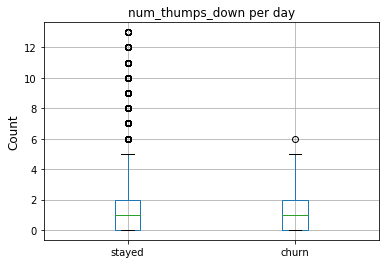

In [89]:
make_boxplot('num_thumps_down')

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  5.904682  5.728219  0.0  1.0  4.0  9.0  38.0
 churn      115.0  5.104348  5.466603  0.0  1.0  3.0  7.5  28.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb0820ad0>)

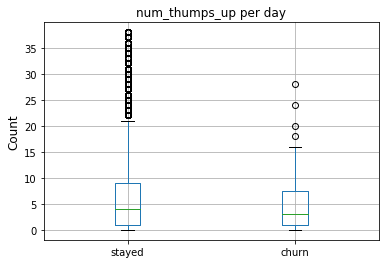

In [90]:
make_boxplot('num_thumps_up')

#### Home

In [91]:
# flag Home
flag_home = F.udf(lambda x: 1 if (x == 'Home') else 0, T.IntegerType())

In [92]:
# create flag columns for home
df_valid = df_valid.withColumn("home", flag_home('page'))

In [93]:
# number of homes in a day
df_valid = df_valid.withColumn("num_homes", F.sum("home").over(windowval))

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  4.507745  3.698652  0.0  2.0  4.0  7.0  22.0
 churn      115.0  3.904348  3.238946  0.0  1.0  3.0  6.0  15.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb14b5d90>)

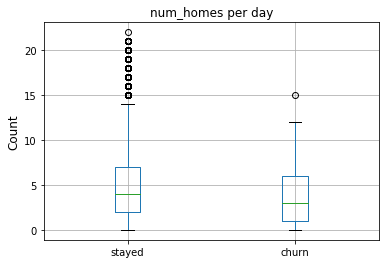

In [94]:
make_boxplot('num_homes')

#### Roll Advert

In [95]:
# flag Roll Advert
flag_roll_advert = F.udf(lambda x: 1 if (x == 'Roll Advert') else 0, T.IntegerType())

In [96]:
# create flag columns for roll advert
df_valid = df_valid.withColumn("roll_advert", flag_roll_advert('page'))

In [97]:
# number of roll_adverts in a day
df_valid = df_valid.withColumn("num_roll_adverts", F.sum("roll_advert").over(windowval))

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  1.058636  2.641766  0.0  0.0  0.0  1.0  38.0
 churn      115.0  1.626087  3.745081  0.0  0.0  0.0  1.0  25.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb07316d0>)

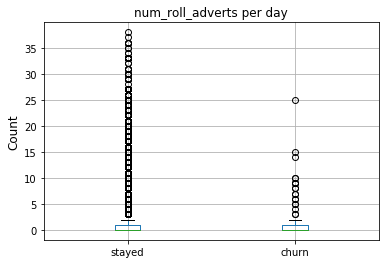

In [98]:
make_boxplot('num_roll_adverts')

#### Logout

In [99]:
# flag Logout
flag_logout = F.udf(lambda x: 1 if (x == 'Logout') else 0, T.IntegerType())

In [100]:
# create flag columns for logout
df_valid = df_valid.withColumn("logout", flag_logout('page'))

In [101]:
# number of logouts in a day
df_valid = df_valid.withColumn("num_logouts", F.sum("logout").over(windowval))

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  1.316290  1.532632  0.0  0.0  1.0  2.0  10.0
 churn      115.0  1.095652  1.263342  0.0  0.0  1.0  2.0   5.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb0f34450>)

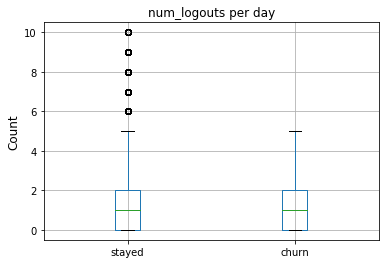

In [102]:
make_boxplot('num_logouts')

#### Settings 

In [103]:
# flag Settings
flag_settings = F.udf(lambda x: 1 if (x == 'Settings') else 0, T.IntegerType())

In [104]:
# create flag columns for settings
df_valid = df_valid.withColumn("settings", flag_settings('page'))

In [105]:
# number of home in a day
df_valid = df_valid.withColumn("num_settings", F.sum("settings").over(windowval))

(           count      mean       std  min  25%  50%  75%  max
 stayed  278039.0  0.695895  1.043436  0.0  0.0  0.0  1.0  8.0
 churn      115.0  0.782609  1.074282  0.0  0.0  0.0  1.0  5.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb1460210>)

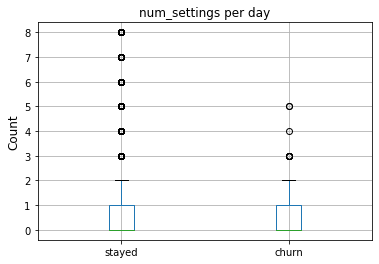

In [106]:
make_boxplot('num_settings')

#### Add to Playlist 

In [107]:
# flag Add to Playlist
flag_add_playlist = F.udf(lambda x: 1 if (x == 'Add to Playlist') else 0, T.IntegerType())

In [108]:
# create flag columns for add to playlist
df_valid = df_valid.withColumn("playlist", flag_add_playlist('page'))

In [109]:
# number of add to playlists in a day
df_valid = df_valid.withColumn("num_playlists", F.sum("playlist").over(windowval))

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  3.121458  3.184323  0.0  1.0  2.0  5.0  19.0
 churn      115.0  2.460870  2.659927  0.0  0.0  2.0  3.5  13.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccafc1b650>)

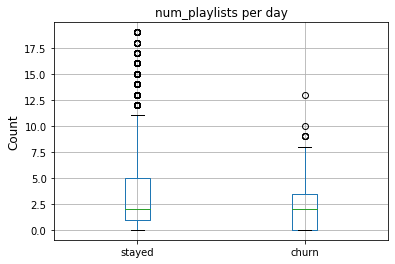

In [110]:
make_boxplot('num_playlists')

#### Add Friend 

In [111]:
# flag Add Friend
flag_add_friend = F.udf(lambda x: 1 if (x == 'Add Friend') else 0, T.IntegerType())

In [112]:
# create flag column for add friend
df_valid = df_valid.withColumn("friend", flag_add_playlist('page'))

In [113]:
# number of add to friends in a day
df_valid = df_valid.withColumn("num_friends", F.sum("friend").over(windowval))

(           count      mean       std  min  25%  50%  75%   max
 stayed  278039.0  3.121458  3.184323  0.0  1.0  2.0  5.0  19.0
 churn      115.0  2.460870  2.659927  0.0  0.0  2.0  3.5  13.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb5b12f50>)

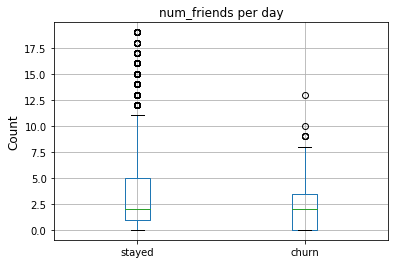

In [114]:
make_boxplot('num_friends')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.